In [3]:
import numpy as np
import matplotlib.pyplot as plt

import pyspark.sql.functions as F

from pyspark.sql.dataframe import DataFrame
from pyspark.sql.types import StringType, IntegerType, DateType

from session import spark_session, updata

spark = spark_session()
data: DataFrame = updata(spark)
    
data.show(vertical=True)

-RECORD 0-----------------------------------------------------------------------------------------
 state                                                                        | VT                
 date                                                                         | 2020/10/16        
 critical_staffing_shortage_today_yes                                         | 1                 
 critical_staffing_shortage_today_no                                          | 15                
 critical_staffing_shortage_today_not_reported                                | 1                 
 critical_staffing_shortage_anticipated_within_week_yes                       | 1                 
 critical_staffing_shortage_anticipated_within_week_no                        | 15                
 critical_staffing_shortage_anticipated_within_week_not_reported              | 1                 
 hospital_onset_covid                                                         | 0                 
 hospital_

1 - ¿Cuáles fueron los 5 Estados con mayor ocupación hospitalaria por COVID? Criterio de ocupación por cama común. Considere la cantidad de camas ocupadas con pacientes confirmados y tome como referencia los 6 primeros meses del 2020 - recuerde incluir la cifra de infectados en esos meses (acumulativo). ¿Influye el rango etario en este comportamiento?

In [4]:
data1: DataFrame = (
    data.select(
        F.col("inpatient_beds_used_covid")
        .alias("beds")
        .cast(IntegerType()),
        \
        F.from_unixtime(
            F.unix_timestamp("date", "yyyy/MM/dd")
        ).alias("date")
        .cast(DateType()),
        \
        F.col("state")
        .cast(StringType())
    )
    .dropna()
    .filter(
        (F.col("date").between('2020-01-01', '2020-06-30'))
        & ( F.col("beds") > 0),
    )
    .groupBy("state", "date")
    .sum()
    .withColumnRenamed("sum(beds)", "beds")
    .sort(F.col("date"))
)
data1.show()


top5: np.ndarray = np.array(
    data1.select("state", "beds")
    .groupBy("state")
    .sum()
    .withColumnRenamed("sum(beds)", "beds")
    .sort(F.desc("beds"))
    .limit(5)
    .collect()
)[:, 0]

+-----+----------+----+
|state|      date|beds|
+-----+----------+----+
|   NV|2020-01-02|1877|
|   NV|2020-01-03|1877|
|   NV|2020-01-04|1877|
|   NV|2020-01-05|1877|
|   NV|2020-01-06|1877|
|   CA|2020-02-04|  14|
|   CA|2020-02-05|  14|
|   CA|2020-02-06|  14|
|   CA|2020-02-07|  14|
|   CA|2020-02-08|  14|
|   KS|2020-02-15|   1|
|   KS|2020-02-16|   1|
|   KS|2020-02-17|   1|
|   KS|2020-02-18|   1|
|   KS|2020-02-19|   1|
|   TX|2020-02-28|   1|
|   TX|2020-02-29|   1|
|   TX|2020-03-01|   1|
|   IA|2020-03-02|   2|
|   TX|2020-03-02|   2|
+-----+----------+----+
only showing top 20 rows



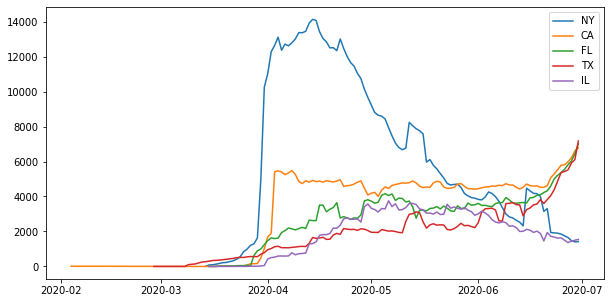

In [5]:
def plot1():
    _, ax = plt.subplots(figsize=(10, 5))
    for state in top5:
        x1: np.ndarray = (
            np.array(
                data1.select("date")
                .filter(
                    (data1.state == state)
                )
                .collect()
            ).reshape(1, -1)[0]
        )
        y1: np.ndarray = (
            np.array(
                data1.select("beds")
                .filter(data1.state == state)
                .collect()
            ).reshape(1, -1)[0]
        )

        ax.plot(x1, y1, label=state)

    plt.legend()
    plt.savefig('./plots/top5_states.png', dpi=100)
    plt.show()

plot1()

2 - Analice la ocupación de camas (Común) por COVID en el Estado de Nueva York durante la cuarentena establecida e indique:

    Intervalos de crecimiento y decrecimiento
    Puntos críticos (mínimos y máximos)

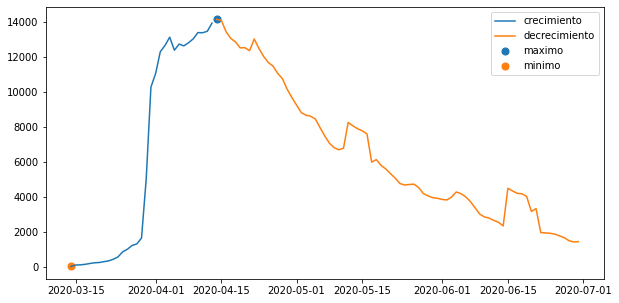

punto maximo:  14126
punto minimo:  6


In [6]:
x2: np.ndarray = (
    np.array(
        data1.select("date")
        .filter(
            (data1.state == 'NY')
        )
        .collect()
    ).reshape(1, -1)[0]
)

y2: np.ndarray = (
    np.array(
        data1.select("beds")
        .filter(data1.state == 'NY')
        .collect()
    ).reshape(1, -1)[0]
)


max_index: int = np.where(y2 == max(y2))[0][0]

increment_range: np.ndarray = np.concatenate(
  [y2[:max_index], np.zeros(len(y2) - max_index)]
)
increment_range[increment_range == 0] = np.NaN

decrement_range: np.ndarray = np.concatenate(
  [np.zeros(max_index), y2[max_index:]]
)
decrement_range[decrement_range == 0] = np.NaN


def plot2():
    plt.figure(figsize=(10, 5))
    plt.plot(x2, increment_range, label='crecimiento')
    plt.plot(x2, decrement_range, label='decrecimiento')
    plt.scatter(x2[y2 == max(y2)], y2[y2 == max(y2)], label='maximo', s=50)
    plt.scatter(x2[y2 == min(y2)], y2[y2 == min(y2)], label='minimo', s=50)
    plt.legend()
    plt.savefig('./plots/NewYork.png', dpi=100)
    plt.show()

plot2()
print('punto maximo: ', y2[y2 == max(y2)][0])
print('punto minimo: ', y2[y2 == min(y2)][0])

3 - ¿Cuáles fueron los cinco Estados que más camas UCI -Unidades de Cuidados Intensivos- utilizaron durante el año 2020? La medición debe realizarse en términos absolutos.

In [7]:
top5_3: DataFrame = (
    data.select(
        F.from_unixtime(
            F.unix_timestamp("date", "yyyy/MM/dd")
        ).alias("date")
        .cast(DateType()),
        \
        F.col("state")
        .cast(StringType()),
        \
        (
            (F.col("total_staffed_pediatric_icu_beds") +
             F.col("total_staffed_adult_icu_beds"))
        )
        .cast(IntegerType())
        .alias("icu_beds")
    )
    .filter(F.year(F.col("date")) == 2020)
    .groupBy("state")
    .sum()
    .withColumnRenamed("sum(icu_beds)", "icu_beds")
    .sort(F.desc("icu_beds"))
    .limit(5)
)
top5_3.show()

+-----+--------+
|state|icu_beds|
+-----+--------+
|   CA| 1639824|
|   TX| 1237830|
|   FL| 1174171|
|   NY| 1051571|
|   OH|  794195|
+-----+--------+



4 - ¿Qué cantidad de camas se utilizaron, por Estado, para pacientes pediátricos con COVID durante el 2020?

In [8]:
data4: DataFrame = (
    data.select(
        F.from_unixtime(
            F.unix_timestamp("date", "yyyy/MM/dd")
        ).alias("date")
        .cast(DateType()),
        \
        F.col("state")
        .cast(StringType()),
        \
        F.col("total_pediatric_patients_hospitalized_confirmed_covid")
        .cast(IntegerType())
        .alias("pediatric")
    )
    .filter(F.year("date") == 2020)
    .groupBy("state")
    .sum()
    .withColumnRenamed("sum(pediatric)", "pediatric")
    .sort(F.desc("pediatric"))
)
data4.show()

+-----+---------+
|state|pediatric|
+-----+---------+
|   TX|    12582|
|   CA|    10031|
|   FL|     7391|
|   AZ|     5786|
|   PA|     5735|
|   IL|     5311|
|   GA|     5016|
|   NY|     5008|
|   TN|     4056|
|   OK|     3399|
|   CO|     3338|
|   MO|     3142|
|   OH|     3135|
|   AL|     3001|
|   NC|     2184|
|   NJ|     2087|
|   MN|     2027|
|   NE|     2020|
|   SD|     1744|
|   MI|     1724|
+-----+---------+
only showing top 20 rows



5 - ¿Qué porcentaje de camas UCI corresponden a casos confirmados de COVID-19? Agrupe por Estado.

In [9]:
data5: DataFrame = (
    data.select(
        F.col("state")
        .cast(StringType()),
        \
        (F.col("staffed_icu_pediatric_patients_confirmed_covid") +
         F.col("staffed_icu_adult_patients_confirmed_covid"))
        .cast(IntegerType())
        .alias("confirmed")
    )
    .groupBy("state")
    .sum()
    .withColumnRenamed("sum(confirmed)", "confirmed")
    .sort(F.desc("confirmed"))
)
data5.show()

+-----+---------+
|state|confirmed|
+-----+---------+
|   TX|   368459|
|   CA|   288857|
|   FL|   233751|
|   IL|   147444|
|   GA|   114719|
|   NY|   111761|
|   PA|    99589|
|   OH|    99487|
|   NC|    88730|
|   MO|    86397|
|   TN|    84511|
|   AL|    72320|
|   AZ|    67773|
|   MI|    66995|
|   IN|    65835|
|   AR|    61946|
|   VA|    59595|
|   OK|    52607|
|   LA|    51823|
|   SC|    50200|
+-----+---------+
only showing top 20 rows



6 - ¿Cuántas muertes por covid hubo, por Estado, durante el año 2021?

In [10]:
data6: DataFrame = (
    data.select(
        F.from_unixtime(
            F.unix_timestamp("date", "yyyy/MM/dd")
        ).alias("date")
        .cast(DateType()),
        \
        F.col("state")
        .cast(StringType()),
        \
        F.col("deaths_covid")
        .cast(IntegerType())
    )
    .filter(F.year("date") == 2021)
    .groupBy("state")
    .sum()
    .withColumnRenamed("sum(deaths_covid)", "deaths_covid")
    .sort(F.desc("deaths_covid"))
)
data6.show()

+-----+------------+
|state|deaths_covid|
+-----+------------+
|   CA|       35108|
|   TX|       32889|
|   FL|       26004|
|   NY|       17620|
|   AZ|       16250|
|   PA|       13363|
|   GA|       12338|
|   OH|       12023|
|   NC|       10922|
|   TN|        9439|
|   MI|        9332|
|   IL|        7500|
|   KY|        7252|
|   NJ|        6889|
|   VA|        6479|
|   SC|        6434|
|   AL|        6390|
|   MO|        6285|
|   IN|        5846|
|   PR|        4516|
+-----+------------+
only showing top 20 rows



7 - ¿Qué relación presenta la falta de camas UCI disponibles con la cantidad de muertes durante el año 2021?

Correlacion: 0.70


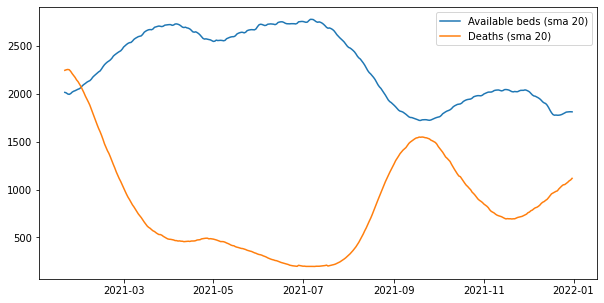

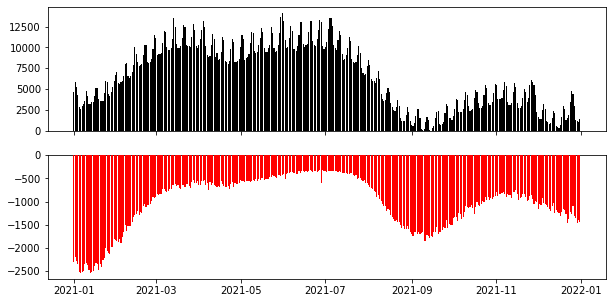

In [11]:
data7: DataFrame = (
    data.select(
        F.from_unixtime(
            F.unix_timestamp("date", "yyyy/MM/dd")
        ).alias("date")
        .cast(DateType()),
        \
        (F.col("adult_icu_bed_utilization_denominator") -
         F.col("adult_icu_bed_utilization_numerator"))
        .cast(IntegerType())
        .alias("available"),
        \
        F.col("deaths_covid")
        .cast(IntegerType())
        .alias("deaths")
    )
    .filter(F.year("date") == 2021)
    .groupBy("date")
    .sum()
    .withColumnRenamed("sum(available)", "available")
    .withColumnRenamed("sum(deaths)", "deaths")
    .sort("date")
)

print("Correlacion: %.2f" % data7.corr("available", "deaths").__abs__())


axes: np.ndarray = np.array(data7.collect())


def ma20(x: int) -> np.ndarray:
    return np.convolve(axes[:, x], np.ones(20), 'valid') / 20


def plot7() -> None:
    _, ax7_1 = plt.subplots(figsize=(10, 5))
    ax7_1.plot(axes[19:, 0], ma20(1) / 10, label="Available beds (sma 20)")
    ax7_1.plot(axes[19:, 0], ma20(2), label="Deaths (sma 20)")
    ax7_1.legend()
    plt.show()

    fig, (ax7_a, ax7_b) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    ax7_a.bar(
        axes[:, 0],
        axes[:, 1] - min(axes[:, 1]),
        label="Available",
        align='center',
        zorder=10,
        color='black'
    )
    ax7_b.bar(
        axes[:, 0],
        ~axes[:, 2] - min(axes[:, 2]),
        label="Deaths",
        align='center',
        zorder=10,
        color='red'
    )
    plt.subplots_adjust(
        left=None,
        bottom=None,
        right=None,
        top=None,
        wspace=None,
        hspace=None)
    plt.show()
    
plot7()

In [12]:
(
    data.select()
)

DataFrame[]

8 - Siguiendo las respuestas anteriores, ¿cuál fue el peor mes de la pandemia para USA en su conjunto? Puede utilizar otras medidas que considere necesarias.

9 - ¿Qué recomendaciones haría, ex post, con respecto a los recursos hospitalarios y su uso?

Respuesta: Tomando como dato con mayor importancia las muertes y su correlacion tan grande con la falta de camas.              En caso de una pandemia se debe invertir en estas camas, tanto comunes como de cuidados intensivos
